<div class="output_png output_subarea output_execute_result">
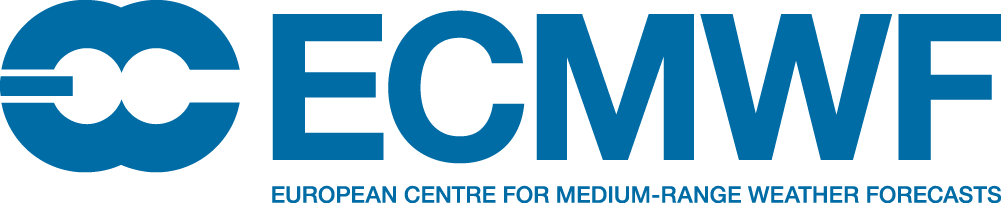
</div>

# 	Bulk wind shear (Compute from levels)

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-bulk-shear  
You can read more about bulk wind shear in [this document](https://www.ecmwf.int/en/elibrary/19905-vertical-wind-shear-and-convective-storms).

<div class="output_png output_subarea output_execute_result">
<center>
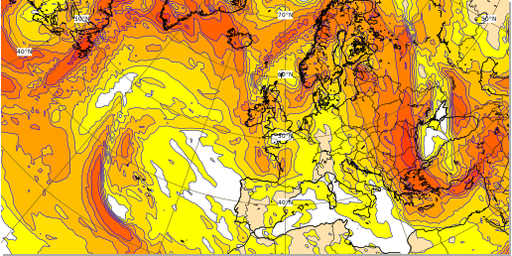</center>
</div>

The full list of available Open data products can be found [here](https://www.ecmwf.int/en/forecasts/datasets/open-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts+from+IFS+and+AIFS).  

Access to ECMWF Open data is governed by the Creative Commons CC-BY-4.0 licence and associated [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).  

<sub> In applying this licence, ECMWF does not waive the privileges and immunities granted to it by virtue of its status as an intergovernmental organisation nor does it submit to any jurisdiction </sub>

To find out how to obtain the access to the full forecast dataset at higher resolution please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 4 parameters :

* [U component of wind](https://codes.ecmwf.int/grib/param-db/131)
* [V component of wind](https://codes.ecmwf.int/grib/param-db/132)
* [10 metre U wind component](https://codes.ecmwf.int/grib/param-db/165)
* [10 metre V wind component](https://codes.ecmwf.int/grib/param-db/166)

In this example, we will use: 
- [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-opendata metview metview-python

In [1]:
import metview as mv
from ecmwf.opendata import Client

In [2]:
client = Client("ecmwf", beta=True)

## Retrieve requests
This product uses parameters with different vertical levels.  
10u and 10v belong to surface parameters, while u and v are pressure level parameters.  
The two types of levels can not be in the same request, so we need to make two requests for them. 

In [3]:
sfc_parameters = ['10u', '10v']
sfc_filename = 'medium-bulk-shear_sfc.grib'
sfc_filename

'medium-bulk-shear_sfc.grib'

In [4]:
pl_parameters = ['u', 'v']
pl_filename = 'medium-bulk-shear_pl.grib'
pl_filename

'medium-bulk-shear_pl.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

In [5]:
client.retrieve(
    date=0,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="sfc",
    param=sfc_parameters,
    target=sfc_filename
)

20250108000000-12h-oper-fc.grib2:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

In [6]:
client.retrieve(
    date=0,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[1000,925,850,700,500,300,250,200,50],
    param=pl_parameters,
    target=pl_filename
)

20250108000000-12h-oper-fc.grib2:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

## Reading and processing the data
Now we can use **Metview's read() function** to read the files.

In [7]:
sfc_data = mv.read(sfc_filename)
pl_data = mv.read(pl_filename)

The **describe()** function will give us the overview of the datasets.  

In [8]:
sfc_data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
10u,heightAboveGround,10,20250108,0,12,None,165,od,oper,fc,0001
10v,heightAboveGround,10,20250108,0,12,None,166,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [9]:
pl_data.describe('u')

shortName,u
name,U component of wind
paramId,131
units,m s**-1
typeOfLevel,isobaricInhPa
level,"50,200,250,300,500,700,850,925,1000"
date,20250108
time,0
step,12
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.

In [10]:
pl_data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,v,isobaricInhPa,1000,20250108,0,12,fc,None,regular_ll
1,ecmf,u,isobaricInhPa,1000,20250108,0,12,fc,None,regular_ll
2,ecmf,v,isobaricInhPa,300,20250108,0,12,fc,None,regular_ll
3,ecmf,u,isobaricInhPa,300,20250108,0,12,fc,None,regular_ll
4,ecmf,u,isobaricInhPa,250,20250108,0,12,fc,None,regular_ll
5,ecmf,v,isobaricInhPa,250,20250108,0,12,fc,None,regular_ll
6,ecmf,v,isobaricInhPa,500,20250108,0,12,fc,None,regular_ll
7,ecmf,u,isobaricInhPa,500,20250108,0,12,fc,None,regular_ll
8,ecmf,u,isobaricInhPa,200,20250108,0,12,fc,None,regular_ll


### Calculate bulk wind shear intesity between 10 m and 500 hPa
We can calculate bulk wind shear between any two levels in our dataest.  
In this case we will take the 10 m for lower level and 500 hPa for the higher level.  

First we filter out u and v component for each level, using the **select()** method.

In [11]:
u1 = sfc_data.select(shortName=['10u'])
u1.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
10u,heightAboveGround,10,20250108,0,12,None,165,od,oper,fc,0001


In [12]:
v1 = sfc_data.select(shortName=['10v'])
v1.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
10v,heightAboveGround,10,20250108,0,12,None,166,od,oper,fc,0001


In [13]:
u2 = pl_data.select(shortName='u',level=500)
u2.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
u,isobaricInhPa,500,20250108,0,12,None,131,od,oper,fc,0001


In [14]:
v2 = pl_data.select(shortName='v',level=500)
v2.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
v,isobaricInhPa,500,20250108,0,12,None,132,od,oper,fc,0001


And finally we calculate the wind shear intensity:

In [15]:
shear_intensity = mv.sqrt((u1-u2)*(u1-u2)+(v1-v2)*(v1-v2))
shear_intensity.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,10u,heightAboveGround,10,20250108,0,12,fc,None,regular_ll


## Plotting the data
Now, we can plot the data on the map. 

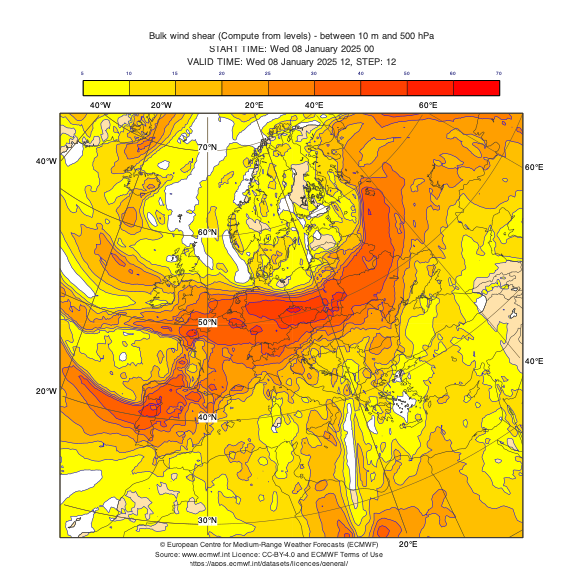

In [16]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
shear_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_red_f5t70lst")

title = mv.mtext(
    text_lines=["Bulk wind shear (Compute from levels) - between 10 m and 500 hPa", 
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H'/> ",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H'/>, STEP: <grib_info key='step' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, shear_intensity, shear_shade, title, ecmwf_text)

To generate the png file you can run the following cell.

In [17]:
png = mv.png_output(
      output_name = "medium-bulk-shear",   # specify relative or full path
      output_title = "medium-bulk-shear",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, shear_intensity, shear_shade, title, ecmwf_text)

Note that plot produced using open data dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
Open data is on 0.25x0.25 resolution, while high resolution data is 0.1x0.1 grid.